# NLP

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using "T4 GPU".

### a. GRU

Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory (LSTM) with a gating mechanism to input or forget certain features, but lacks a context vector or output gate, resulting in fewer parameters than LSTM. GRU's performance on certain tasks of polyphonic music modeling, speech signal modeling and natural language processing was found to be similar to that of LSTM. GRUs showed that gating is indeed helpful in general, and Bengio's team came to no concrete conclusion on which of the two gating units was better.

GRU.svg

### b. LSTM

Long short-term memory (LSTM) network is a recurrent neural network (RNN), aimed to deal with the vanishing gradient problem present in traditional RNNs. Its relative insensitivity to gap length is its advantage over other RNNs, hidden Markov models and other sequence learning methods. It aims to provide a short-term memory for RNN that can last thousands of timesteps, thus "long short-term memory". It is applicable to classification, processing and predicting data based on time series, such as in handwriting, speech recognition, machine translation, speech activity detection, robot control, video games, and healthcare.

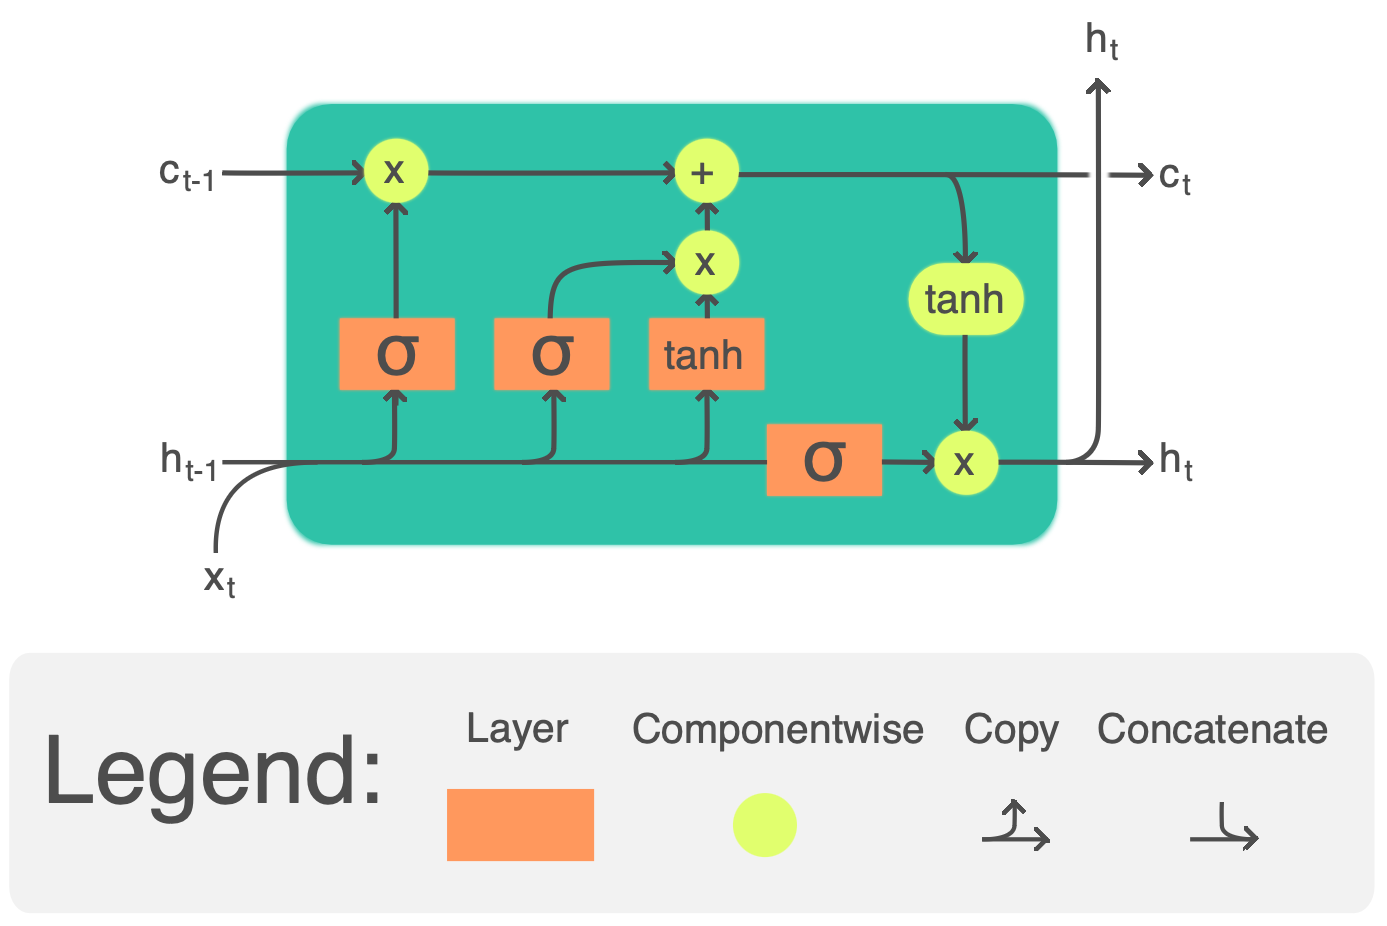

### Input Data

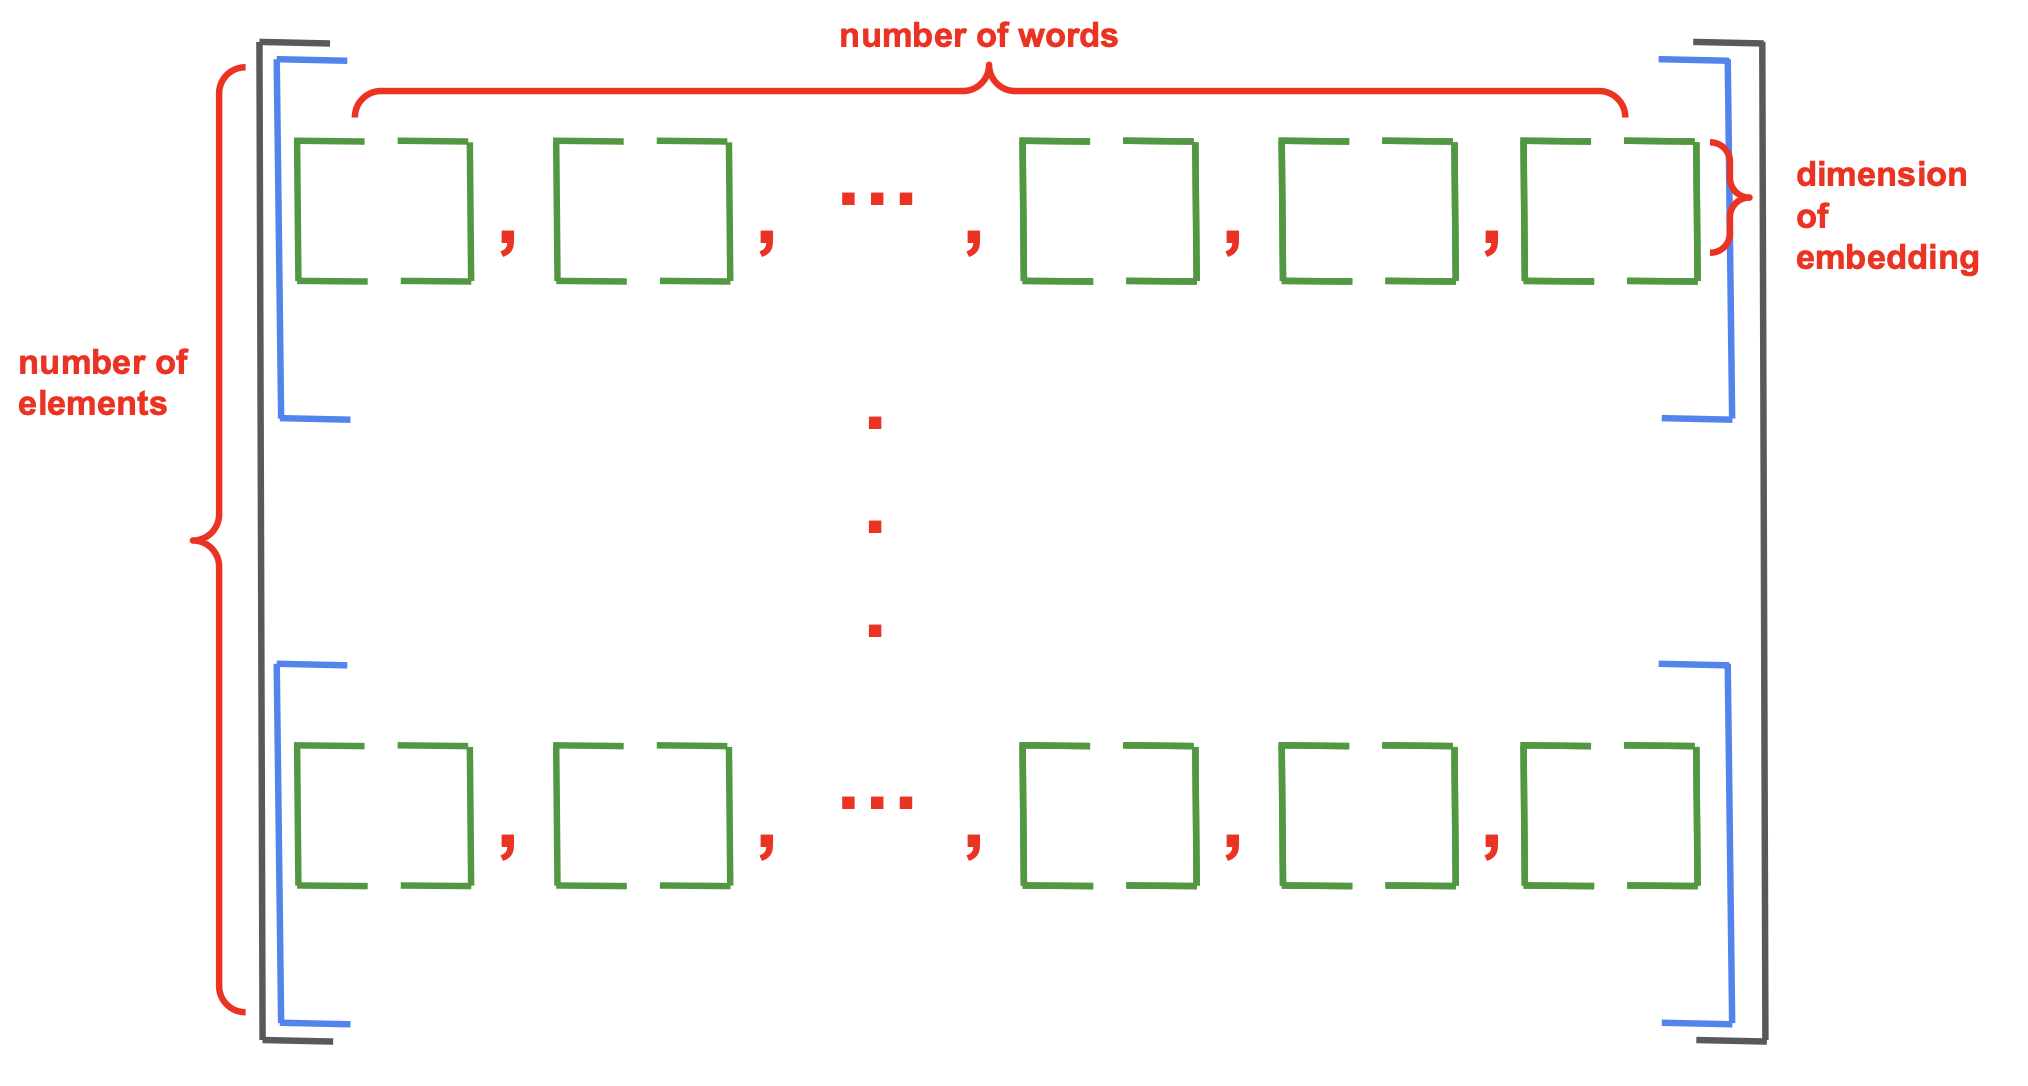

**Data Type at Entry:** Array.

**Data Type at Output:** Array.

In [1]:
import time
import torch
import keras
import numpy as np
import pandas as pd
import torch.nn as nn
from keras.layers import Dense
from keras import regularizers
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [2]:
def print_time_execution(start, end, txt):

  delta = int(end - start)

  hours = int(delta/3_600)
  mins = int((delta - 3_600*hours)/60)
  segs = int(delta - hours*3600 - mins*60)

  return f'{txt} it takes {hours} hours, {mins} mins and {segs} segs.'

### Start time of execution

In [3]:
start = time.time()

# 1. Read Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = 'drive/MyDrive/Github_Alberto_Valdes/Deep_Learning/NLP/SMSSpamCollection'

In [6]:
with open(path) as file:
  data = file.readlines()

In [7]:
data = [i.split('\t') for i in data]

In [8]:
all_txt = [i[1] for i in data]
label = [i[0] for i in data]

In [9]:
df = pd.DataFrame({'txt': all_txt, 'class': label})

In [10]:
df = df.replace({'class': {'spam': 1, 'ham': 0}})

In [11]:
round(df['class'].value_counts(normalize = True)*100, 2)

0    86.6
1    13.4
Name: class, dtype: float64

We would use techniques for imbalanced datasets, but for now we wont use it.

### i. Remove special characters

In [12]:
signs = []

for i in range(len(data)):

  txt_part = df['txt'].iloc[i]

  for c in txt_part:

    if c.isalpha() == True or c.isdigit() == True:
      pass

    else:

      if (c in signs) == False:
        signs.append(c)

signs.remove(' ')

In [13]:
len(signs)

46

In [14]:
def remove_signs(txt, signs):

  new_txt = ''

  for c in txt:

    if c in signs:
      pass

    else:
      new_txt = new_txt + c

  return new_txt

In [15]:
df['txt'] = df['txt'].map(lambda x: remove_signs(x, signs))

### ii. Lower Case

In [16]:
df['txt'] = df['txt'].map(lambda x: x.lower())

In [17]:
X = df[['txt']].copy()
y = df['class'].copy()

### iii. Split

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [19]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 42)

### iv. Tokenization

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
def txt_to_vec(text, max_len, embedding):

  vec_txt = []

  split_text = text.split(' ')
  split_text = split_text[0: max_len]

  for i in range(max_len):

    try:
      s_t = split_text[i]
      vec_txt.append(embedding[s_t])

    except:
      vec_txt.append(np.zeros(300))

  return vec_txt

In [22]:
def word_2_vec(input_X, input_y, embedding, n_batches, max_len):

  output_X = []
  output_y = []

  h_batches = int(len(input_X)/n_batches) + 1

  for n_batch in range(n_batches):

    input_X_batch = input_X.iloc[n_batch*h_batches: (n_batch + 1)*h_batches]
    input_y_batch = input_y.iloc[n_batch*h_batches: (n_batch + 1)*h_batches]

    out_X = []
    out_y = []

    for i in range(len(input_X_batch)):

      txt_part = input_X_batch['txt'].iloc[i]
      class_part = input_y_batch.iloc[i]

      out_X.append(txt_to_vec(txt_part, max_len, embedding))

      if class_part == 1:

        out_y.append([1, 0])

      else:

        out_y.append([0, 1])

    output_X.append(np.array(out_X))
    output_y.append(np.array(out_y))

  return output_X, output_y

In [23]:
import gensim.downloader

In [24]:
%%time

glove_vectors = gensim.downloader.load('word2vec-google-news-300')

CPU times: user 52.7 s, sys: 4.25 s, total: 56.9 s
Wall time: 57.7 s


In [25]:
max_len = 40
n_batches_train = 4

In [26]:
X_train_c, y_train_c = word_2_vec(X_train, y_train, glove_vectors, 1, max_len)

In [27]:
X_val_c, y_val_c = word_2_vec(X_val, y_val, glove_vectors, 1, max_len)

In [28]:
X_test_c, y_test_c = word_2_vec(X_test, y_test, glove_vectors, 1, max_len)

In [29]:
X_train_c = X_train_c[0]
y_train_c = y_train_c[0]

In [30]:
X_val_c = X_val_c[0]
y_val_c = y_val_c[0]

In [31]:
X_test_c = X_test_c[0]
y_test_c = y_test_c[0]

# 2. Creation model

In [32]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [33]:
from keras.layers import Softmax

from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import LSTM

In [34]:
def get_model(hidden_dim, output_size, lr, n_epochs, class_model, verbose):

  model = Sequential()

  model.add(class_model(hidden_dim))
  model.add(Dense(output_size))
  model.add(Softmax())

  model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'binary_crossentropy')

  hist = model.fit(X_train_c, y_train_c, validation_data = (X_val_c, y_val_c), epochs = n_epochs, batch_size = 1_000, verbose = verbose)

  all_loss_train = np.array(hist.history['loss'])
  all_loss_val = np.array(hist.history['val_loss'])
  all_n_epochs = np.array([i for i in range(1, n_epochs + 1)])

  return model, all_n_epochs, all_loss_train, all_loss_val

# 3. Activate GPU

In [35]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [36]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17294760746427445863
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13854638080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17574587909263892988
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# 4. Hyperparameter Tuning

In [37]:
all_hidden_dim = [(30*i) for i in range(3, 7 + 1)]
all_lr = [(0.001*i) for i in range(1, 1 + 1)]
all_n_epochs = [(10*i) for i in range(2, 3 + 1)]
output_size = 2

### a. RNN

In [38]:
start_rnn = time.time()
class_model = SimpleRNN

In [39]:
lr_col = []
n_epochs_col = []
hidden_dim_col = []
recall_val_col = []


for lr in all_lr:
  for n_epochs in all_n_epochs:
    for hidden_dim in all_hidden_dim:

        print('\n')

        print('Hyperparameters:')

        print('\n')

        print('LR:', lr)
        print('N epochs:', n_epochs)
        print('Hidden dim:', hidden_dim)

        print('\n')

        model, _, _, _ = get_model(hidden_dim, output_size, lr, n_epochs, class_model, 0)

        y_val_prob = model(X_val_c).numpy()[:, 0]
        y_val_pred = (y_val_prob > 0.134)*1
        recall_val = round(recall_score(y_val_c[:, 0], y_val_pred)*100, 2)

        print('Recall val: ', recall_val)

        print('\n')

        print('-'*70)

        lr_col.append(lr)
        n_epochs_col.append(n_epochs)
        hidden_dim_col.append(hidden_dim)
        recall_val_col.append(recall_val)

        del model

ht = pd.DataFrame()
ht['lr'] = lr_col
ht['n_epochs'] = n_epochs_col
ht['hidden_dim'] = hidden_dim_col
ht['recall_val'] = recall_val_col



Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 90


Recall val:  0.0


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 120


Recall val:  91.72


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 150


Recall val:  94.48


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 180


Recall val:  88.97


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 210


Recall val:  0.0


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 30
Hidden dim: 90


Recall val:  95.86


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 30
Hidden dim: 120


Recall val:  94.48



In [40]:
ht_opt_rnn = ht[ht['recall_val'] == ht['recall_val'].max()].iloc[[0]]

In [41]:
recall_opt_rnn = ht_opt_rnn['recall_val'].iloc[0]
hidden_dim_opt_rnn = int(ht_opt_rnn['hidden_dim'].iloc[0])
lr_opt_rnn = ht_opt_rnn['lr'].iloc[0]
n_epochs_opt_rnn = int(ht_opt_rnn['n_epochs'].iloc[0])

In [42]:
print('Optimal recall:', recall_opt_rnn)
print('Hidden dim (Opt):', hidden_dim_opt_rnn)
print('LR (Opt):', lr_opt_rnn)
print('N epochs (Opt):', n_epochs_opt_rnn)

Optimal recall: 95.86
Hidden dim (Opt): 90
LR (Opt): 0.001
N epochs (Opt): 30


In [43]:
end_rnn = time.time()
print_time_execution(start_rnn, end_rnn, f'Tuning the RNN')

'Tuning the RNN it takes 0 hours, 2 mins and 15 segs.'

### b. GRU

In [44]:
start_gru = time.time()
class_model = GRU

In [45]:
lr_col = []
n_epochs_col = []
hidden_dim_col = []
recall_val_col = []


for lr in all_lr:
  for n_epochs in all_n_epochs:
    for hidden_dim in all_hidden_dim:

        print('\n')

        print('Hyperparameters:')

        print('\n')

        print('LR:', lr)
        print('N epochs:', n_epochs)
        print('Hidden dim:', hidden_dim)

        print('\n')

        model, _, _, _ = get_model(hidden_dim, output_size, lr, n_epochs, class_model, 0)

        y_val_prob = model(X_val_c).numpy()[:, 0]
        y_val_pred = (y_val_prob > 0.134)*1
        recall_val = round(recall_score(y_val_c[:, 0], y_val_pred)*100, 2)

        print('Recall val: ', recall_val)

        print('\n')

        print('-'*70)

        lr_col.append(lr)
        n_epochs_col.append(n_epochs)
        hidden_dim_col.append(hidden_dim)
        recall_val_col.append(recall_val)

        del model

ht = pd.DataFrame()
ht['lr'] = lr_col
ht['n_epochs'] = n_epochs_col
ht['hidden_dim'] = hidden_dim_col
ht['recall_val'] = recall_val_col



Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 90


Recall val:  87.59


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 120


Recall val:  91.72


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 150


Recall val:  88.97


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 180


Recall val:  91.03


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 210


Recall val:  89.66


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 30
Hidden dim: 90


Recall val:  90.34


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 30
Hidden dim: 120


Recall val:  89.

In [46]:
ht_opt_gru = ht[ht['recall_val'] == ht['recall_val'].max()].iloc[[0]]

In [47]:
recall_opt_gru = ht_opt_gru['recall_val'].iloc[0]
hidden_dim_opt_gru = int(ht_opt_gru['hidden_dim'].iloc[0])
lr_opt_gru = ht_opt_gru['lr'].iloc[0]
n_epochs_opt_gru = int(ht_opt_gru['n_epochs'].iloc[0])

In [48]:
print('Optimal recall:', recall_opt_gru)
print('Hidden dim (Opt):', hidden_dim_opt_gru)
print('LR (Opt):', lr_opt_gru)
print('N epochs (Opt):', n_epochs_opt_gru)

Optimal recall: 93.1
Hidden dim (Opt): 210
LR (Opt): 0.001
N epochs (Opt): 30


In [49]:
end_gru = time.time()
print_time_execution(start_gru, end_gru, f'Tuning the GRU')

'Tuning the GRU it takes 0 hours, 2 mins and 8 segs.'

### c. LSTM

In [50]:
start_lstm = time.time()
class_model = LSTM

In [51]:
lr_col = []
n_epochs_col = []
hidden_dim_col = []
recall_val_col = []


for lr in all_lr:
  for n_epochs in all_n_epochs:
    for hidden_dim in all_hidden_dim:

        print('\n')

        print('Hyperparameters:')

        print('\n')

        print('LR:', lr)
        print('N epochs:', n_epochs)
        print('Hidden dim:', hidden_dim)

        print('\n')

        model, _, _, _ = get_model(hidden_dim, output_size, lr, n_epochs, class_model, 0)

        y_val_prob = model(X_val_c).numpy()[:, 0]
        y_val_pred = (y_val_prob > 0.134)*1
        recall_val = round(recall_score(y_val_c[:, 0], y_val_pred)*100, 2)

        print('Recall val: ', recall_val)

        print('\n')

        print('-'*70)

        lr_col.append(lr)
        n_epochs_col.append(n_epochs)
        hidden_dim_col.append(hidden_dim)
        recall_val_col.append(recall_val)

        del model

ht = pd.DataFrame()
ht['lr'] = lr_col
ht['n_epochs'] = n_epochs_col
ht['hidden_dim'] = hidden_dim_col
ht['recall_val'] = recall_val_col



Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 90


Recall val:  0.0


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 120


Recall val:  0.0


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 150


Recall val:  90.34


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 180


Recall val:  91.03


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 20
Hidden dim: 210


Recall val:  29.66


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 30
Hidden dim: 90


Recall val:  93.79


----------------------------------------------------------------------


Hyperparameters:


LR: 0.001
N epochs: 30
Hidden dim: 120


Recall val:  91.72



In [52]:
ht_opt_lstm = ht[ht['recall_val'] == ht['recall_val'].max()].iloc[[0]]

In [53]:
recall_opt_lstm = ht_opt_lstm['recall_val'].iloc[0]
hidden_dim_opt_lstm = int(ht_opt_lstm['hidden_dim'].iloc[0])
lr_opt_lstm = ht_opt_lstm['lr'].iloc[0]
n_epochs_opt_lstm = int(ht_opt_lstm['n_epochs'].iloc[0])

In [54]:
print('Optimal recall:', recall_opt_lstm)
print('Hidden dim (Opt):', hidden_dim_opt_lstm)
print('LR (Opt):', lr_opt_lstm)
print('N epochs (Opt):', n_epochs_opt_lstm)

Optimal recall: 95.86
Hidden dim (Opt): 180
LR (Opt): 0.001
N epochs (Opt): 30


In [55]:
end_lstm = time.time()
print_time_execution(start_lstm, end_lstm, f'Tuning the LSTM')

'Tuning the LSTM it takes 0 hours, 2 mins and 15 segs.'

# 5. Testing and Calibration

In [56]:
from sklearn.calibration import calibration_curve

In [57]:
def calibration(y, y_pred):

    scores, probs = calibration_curve(y, y_pred, n_bins = 10, normalize = True)

    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect Calibration')
    plt.plot(probs, scores, marker = '.', label = 'Real Calibration')

    leg = plt.legend(loc = 'upper left')

    plt.xlabel('Probability on each bin')
    plt.ylabel('Real probability on each bin')

    plt.title('Calibration')
    plt.show()

### a. RNN

In [58]:
class_model = SimpleRNN

In [59]:
model_rnn, all_n_epochs_rnn, all_loss_train_rnn, all_loss_val_rnn = get_model(hidden_dim_opt_rnn, output_size, lr_opt_rnn, n_epochs_opt_rnn, class_model, 1)

Epoch 1/30
4/4 [==============================] - 3s 234ms/step - loss: 0.6286 - val_loss: 0.4789
Epoch 2/30
4/4 [==============================] - 0s 82ms/step - loss: 0.4464 - val_loss: 0.3942
Epoch 3/30
4/4 [==============================] - 0s 90ms/step - loss: 0.3697 - val_loss: 0.2396
Epoch 4/30
4/4 [==============================] - 0s 83ms/step - loss: 0.2365 - val_loss: 0.1846
Epoch 5/30
4/4 [==============================] - 0s 83ms/step - loss: 0.1840 - val_loss: 0.1518
Epoch 6/30
4/4 [==============================] - 0s 83ms/step - loss: 0.1556 - val_loss: 0.1354
Epoch 7/30
4/4 [==============================] - 0s 83ms/step - loss: 0.1317 - val_loss: 0.1216
Epoch 8/30
4/4 [==============================] - 0s 83ms/step - loss: 0.1099 - val_loss: 0.1117
Epoch 9/30
4/4 [==============================] - 0s 82ms/step - loss: 0.0984 - val_loss: 0.1011
Epoch 10/30
4/4 [==============================] - 0s 85ms/step - loss: 0.0900 - val_loss: 0.1083
Epoch 11/30
4/4 [===========

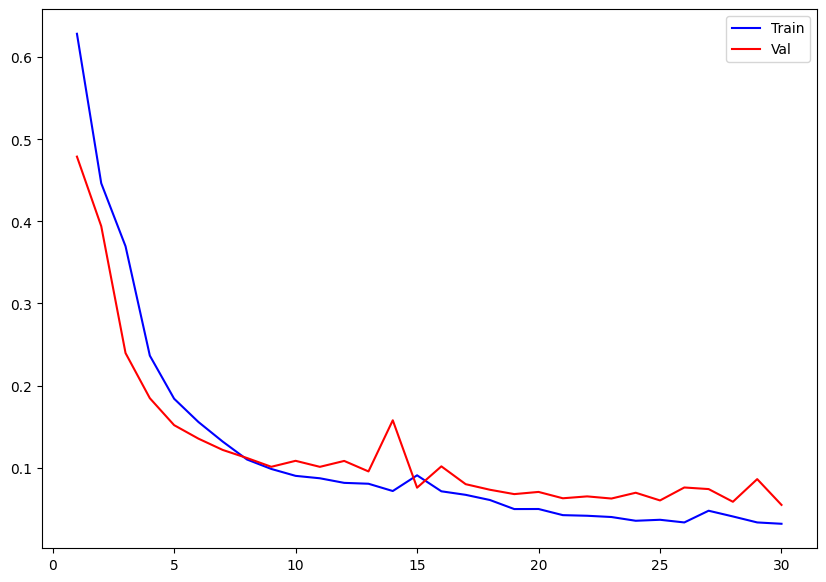

In [60]:
plt.figure(figsize = (10, 7))
plt.plot(all_n_epochs_rnn, all_loss_train_rnn, color = 'blue', label = 'Train')
plt.plot(all_n_epochs_rnn, all_loss_val_rnn, color = 'red', label = 'Val')
plt.legend()
plt.show()

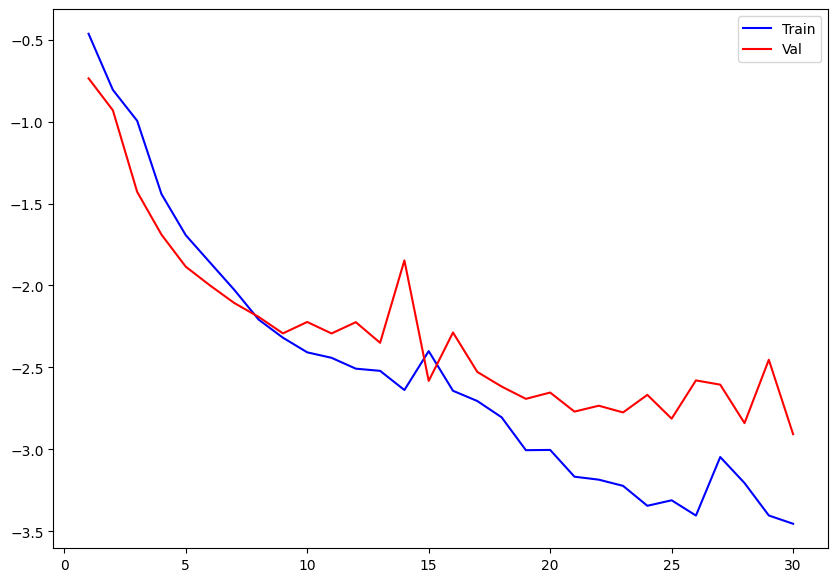

In [61]:
plt.figure(figsize = (10, 7))
plt.plot(all_n_epochs_rnn, np.log(all_loss_train_rnn), color = 'blue', label = 'Train')
plt.plot(all_n_epochs_rnn, np.log(all_loss_val_rnn), color = 'red', label = 'Val')
plt.legend()
plt.show()

In [62]:
y_prob_val = model_rnn(X_val_c).numpy()[:, 0]
y_real_val = y_val_c[:, 0]
y_pred_val = (y_prob_val > 0.134)*1

In [63]:
y_prob_test = model_rnn(X_test_c).numpy()[:, 0]
y_real_test = y_test_c[:, 0]
y_pred_test = (y_prob_test > 0.134)*1

In [64]:
print('Recall val:', round(recall_score(y_real_val, y_pred_val)*100, 2))
print('Precision val:', round(precision_score(y_real_val, y_pred_val)*100, 2))
print('F1 val:', round(f1_score(y_real_val, y_pred_val)*100, 2))
print('Accuracy val:', round(accuracy_score(y_real_val, y_pred_val)*100, 2))

Recall val: 93.1
Precision val: 95.74
F1 val: 94.41
Accuracy val: 98.57


In [65]:
print('Recall test:', round(recall_score(y_real_test, y_pred_test)*100, 2))
print('Precision test:', round(precision_score(y_real_test, y_pred_test)*100, 2))
print('F1 test:', round(f1_score(y_real_test, y_pred_test)*100, 2))
print('Accuracy test:', round(accuracy_score(y_real_test, y_pred_test)*100, 2))

Recall test: 90.97
Precision test: 90.97
F1 test: 90.97
Accuracy test: 97.49


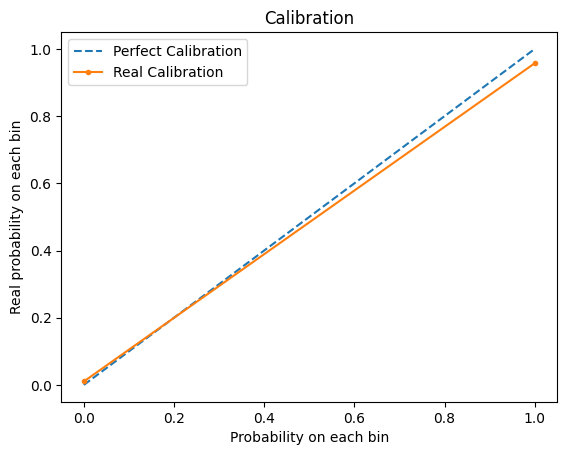

In [66]:
calibration(y_real_val, y_pred_val)

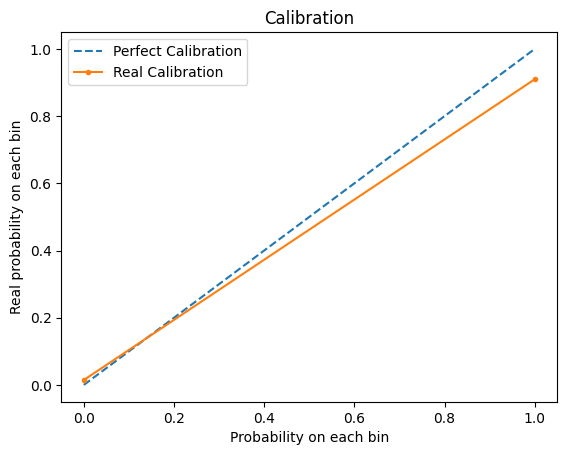

In [67]:
calibration(y_real_test, y_pred_test)

In [68]:
msge_1 = 'Hi Rodrigo! How are you? I hope you very well. Hey dude I invite you to my party!'
msge_2 = 'SUPPORT CHILE !! Send a message to 3311 with the word " Chile " to show your support to your football selection'

In [69]:
df_p = pd.DataFrame({'txt': [msge_1, msge_2], 'class': [0, 1]})

In [70]:
X_p = df_p[['txt']]
y_p = df_p['class']

In [71]:
X_p_c, y_p_c = word_2_vec(X_p, y_p, glove_vectors, 1, max_len)

In [72]:
out_p = model_rnn(X_p_c).numpy()[:, 0]

In [73]:
round(out_p[0]*100, 4)

0.0027

In [74]:
round(out_p[1]*100, 4)

99.9774

### b. GRU

In [75]:
class_model = GRU

In [76]:
model_gru, all_n_epochs_gru, all_loss_train_gru, all_loss_val_gru = get_model(hidden_dim_opt_gru, output_size, lr_opt_gru, n_epochs_opt_gru, class_model, 1)

Epoch 1/30
4/4 [==============================] - 4s 261ms/step - loss: 0.6826 - val_loss: 0.6539
Epoch 2/30
4/4 [==============================] - 0s 77ms/step - loss: 0.6314 - val_loss: 0.5495
Epoch 3/30
4/4 [==============================] - 0s 71ms/step - loss: 0.5099 - val_loss: 0.4362
Epoch 4/30
4/4 [==============================] - 0s 69ms/step - loss: 0.4363 - val_loss: 0.4055
Epoch 5/30
4/4 [==============================] - 0s 71ms/step - loss: 0.4039 - val_loss: 0.3840
Epoch 6/30
4/4 [==============================] - 0s 69ms/step - loss: 0.3868 - val_loss: 0.3734
Epoch 7/30
4/4 [==============================] - 0s 67ms/step - loss: 0.3706 - val_loss: 0.3423
Epoch 8/30
4/4 [==============================] - 0s 68ms/step - loss: 0.2778 - val_loss: 0.3333
Epoch 9/30
4/4 [==============================] - 0s 72ms/step - loss: 0.2073 - val_loss: 0.2096
Epoch 10/30
4/4 [==============================] - 0s 69ms/step - loss: 0.2053 - val_loss: 0.1629
Epoch 11/30
4/4 [===========

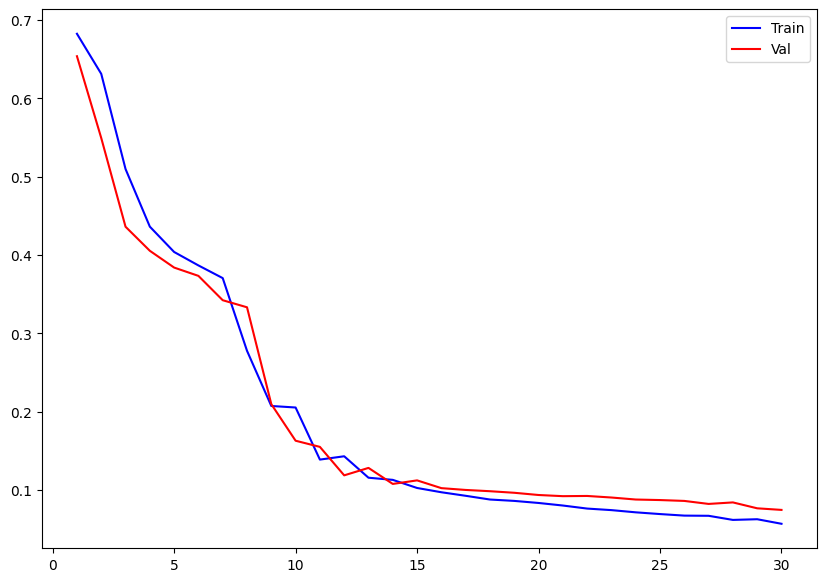

In [77]:
plt.figure(figsize = (10, 7))
plt.plot(all_n_epochs_gru, all_loss_train_gru, color = 'blue', label = 'Train')
plt.plot(all_n_epochs_gru, all_loss_val_gru, color = 'red', label = 'Val')
plt.legend()
plt.show()

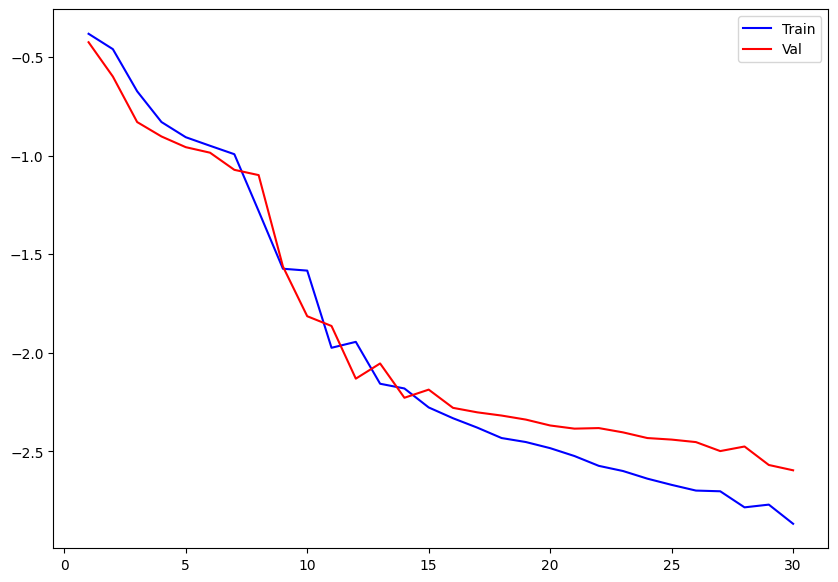

In [78]:
plt.figure(figsize = (10, 7))
plt.plot(all_n_epochs_gru, np.log(all_loss_train_gru), color = 'blue', label = 'Train')
plt.plot(all_n_epochs_gru, np.log(all_loss_val_gru), color = 'red', label = 'Val')
plt.legend()
plt.show()

In [79]:
y_prob_val = model_gru(X_val_c).numpy()[:, 0]
y_real_val = y_val_c[:, 0]
y_pred_val = (y_prob_val > 0.134)*1

In [80]:
y_prob_test = model_gru(X_test_c).numpy()[:, 0]
y_real_test = y_test_c[:, 0]
y_pred_test = (y_prob_test > 0.134)*1

In [81]:
print('Recall val:', round(recall_score(y_real_val, y_pred_val)*100, 2))
print('Precision val:', round(precision_score(y_real_val, y_pred_val)*100, 2))
print('F1 val:', round(f1_score(y_real_val, y_pred_val)*100, 2))
print('Accuracy val:', round(accuracy_score(y_real_val, y_pred_val)*100, 2))

Recall val: 94.48
Precision val: 84.05
F1 val: 88.96
Accuracy val: 96.95


In [82]:
print('Recall test:', round(recall_score(y_real_test, y_pred_test)*100, 2))
print('Precision test:', round(precision_score(y_real_test, y_pred_test)*100, 2))
print('F1 test:', round(f1_score(y_real_test, y_pred_test)*100, 2))
print('Accuracy test:', round(accuracy_score(y_real_test, y_pred_test)*100, 2))

Recall test: 96.13
Precision test: 84.18
F1 test: 89.76
Accuracy test: 96.95


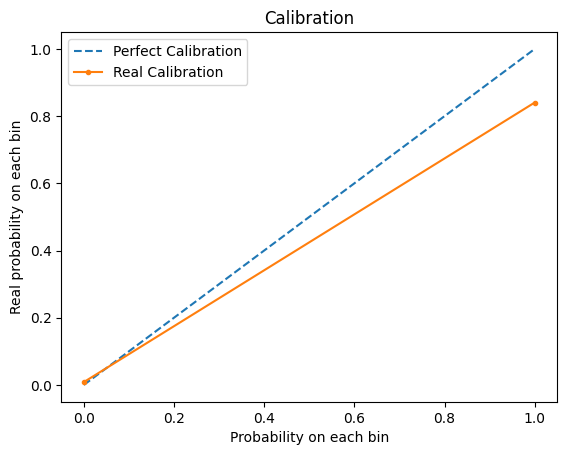

In [83]:
calibration(y_real_val, y_pred_val)

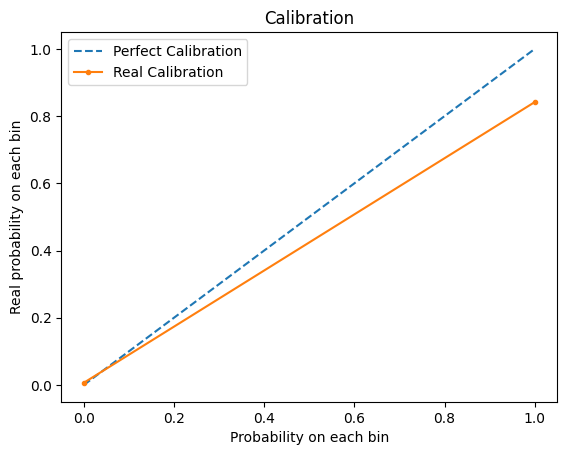

In [84]:
calibration(y_real_test, y_pred_test)

In [85]:
msge_1 = 'Hi Rodrigo! How are you? I hope you very well. Hey dude I invite you to my party!'
msge_2 = 'SUPPORT CHILE !! Send a message to 3311 with the word " Chile " to show your support to your football selection'

In [86]:
df_p = pd.DataFrame({'txt': [msge_1, msge_2], 'class': [0, 1]})

In [87]:
X_p = df_p[['txt']]
y_p = df_p['class']

In [88]:
X_p_c, y_p_c = word_2_vec(X_p, y_p, glove_vectors, 1, max_len)

In [89]:
out_p = model_gru(X_p_c).numpy()[:, 0]

In [90]:
round(out_p[0]*100, 4)

0.0015

In [91]:
round(out_p[1]*100, 4)

99.8806

### c. LSTM

In [92]:
class_model = LSTM

In [93]:
model_lstm, all_n_epochs_lstm, all_loss_train_lstm, all_loss_val_lstm = get_model(hidden_dim_opt_lstm, output_size, lr_opt_lstm, n_epochs_opt_lstm, class_model, 1)

Epoch 1/30
4/4 [==============================] - 3s 275ms/step - loss: 0.6818 - val_loss: 0.6321
Epoch 2/30
4/4 [==============================] - 0s 79ms/step - loss: 0.5546 - val_loss: 0.4420
Epoch 3/30
4/4 [==============================] - 0s 100ms/step - loss: 0.4293 - val_loss: 0.3873
Epoch 4/30
4/4 [==============================] - 0s 72ms/step - loss: 0.4013 - val_loss: 0.4000
Epoch 5/30
4/4 [==============================] - 0s 70ms/step - loss: 0.4003 - val_loss: 0.3854
Epoch 6/30
4/4 [==============================] - 0s 69ms/step - loss: 0.3930 - val_loss: 0.3868
Epoch 7/30
4/4 [==============================] - 0s 67ms/step - loss: 0.3938 - val_loss: 0.3852
Epoch 8/30
4/4 [==============================] - 0s 69ms/step - loss: 0.3914 - val_loss: 0.3843
Epoch 9/30
4/4 [==============================] - 0s 96ms/step - loss: 0.3899 - val_loss: 0.3835
Epoch 10/30
4/4 [==============================] - 0s 71ms/step - loss: 0.3874 - val_loss: 0.3709
Epoch 11/30
4/4 [==========

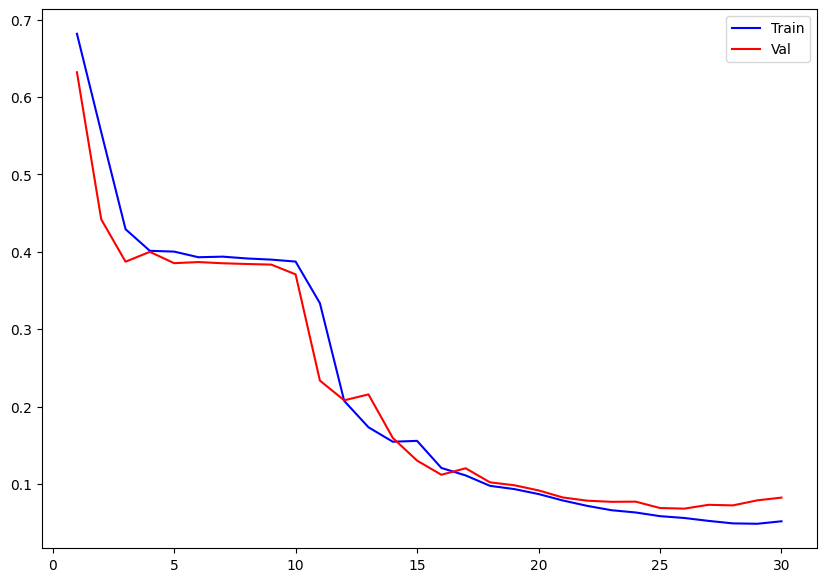

In [94]:
plt.figure(figsize = (10, 7))
plt.plot(all_n_epochs_lstm, all_loss_train_lstm, color = 'blue', label = 'Train')
plt.plot(all_n_epochs_lstm, all_loss_val_lstm, color = 'red', label = 'Val')
plt.legend()
plt.show()

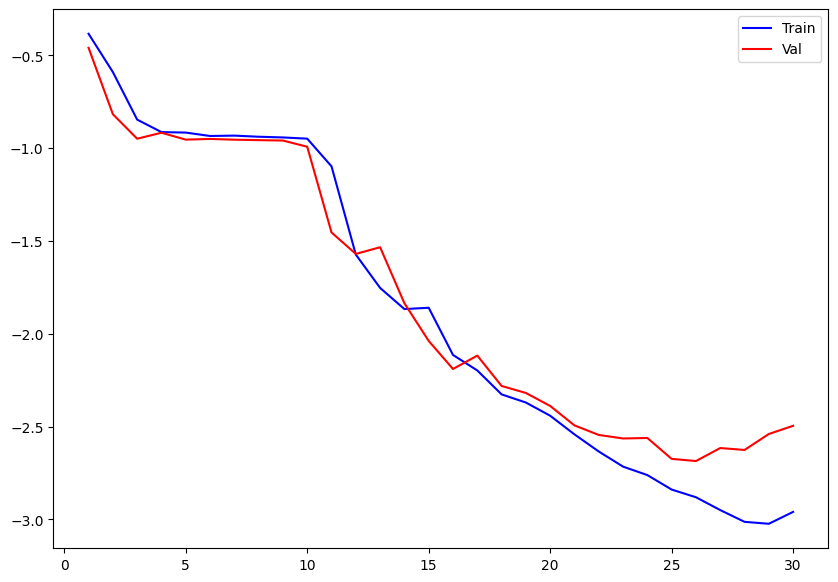

In [95]:
plt.figure(figsize = (10, 7))
plt.plot(all_n_epochs_lstm, np.log(all_loss_train_lstm), color = 'blue', label = 'Train')
plt.plot(all_n_epochs_lstm, np.log(all_loss_val_lstm), color = 'red', label = 'Val')
plt.legend()
plt.show()

In [96]:
y_prob_val = model_lstm(X_val_c).numpy()[:, 0]
y_real_val = y_val_c[:, 0]
y_pred_val = (y_prob_val > 0.134)*1

In [97]:
y_prob_test = model_lstm(X_test_c).numpy()[:, 0]
y_real_test = y_test_c[:, 0]
y_pred_test = (y_prob_test > 0.134)*1

In [98]:
print('Recall val:', round(recall_score(y_real_val, y_pred_val)*100, 2))
print('Precision val:', round(precision_score(y_real_val, y_pred_val)*100, 2))
print('F1 val:', round(f1_score(y_real_val, y_pred_val)*100, 2))
print('Accuracy val:', round(accuracy_score(y_real_val, y_pred_val)*100, 2))

Recall val: 95.17
Precision val: 79.77
F1 val: 86.79
Accuracy val: 96.23


In [99]:
print('Recall test:', round(recall_score(y_real_test, y_pred_test)*100, 2))
print('Precision test:', round(precision_score(y_real_test, y_pred_test)*100, 2))
print('F1 test:', round(f1_score(y_real_test, y_pred_test)*100, 2))
print('Accuracy test:', round(accuracy_score(y_real_test, y_pred_test)*100, 2))

Recall test: 96.13
Precision test: 81.87
F1 test: 88.43
Accuracy test: 96.5


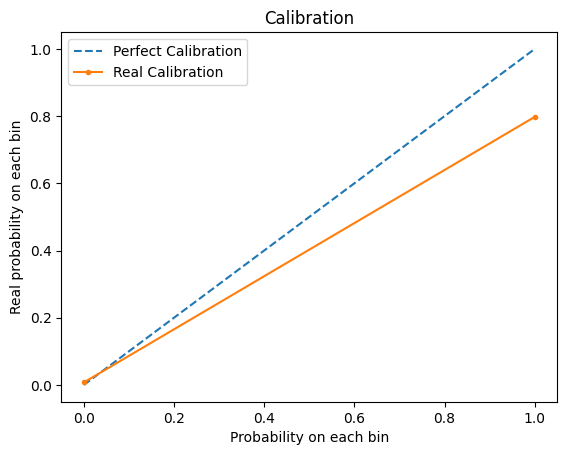

In [100]:
calibration(y_real_val, y_pred_val)

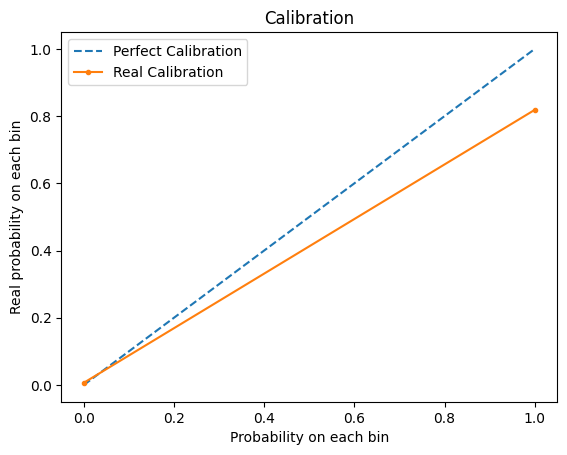

In [101]:
calibration(y_real_test, y_pred_test)

In [102]:
msge_1 = 'Hi Rodrigo! How are you? I hope you very well. Hey dude I invite you to my party!'
msge_2 = 'SUPPORT CHILE !! Send a message to 3311 with the word " Chile " to show your support to your football selection'

In [103]:
df_p = pd.DataFrame({'txt': [msge_1, msge_2], 'class': [0, 1]})

In [104]:
X_p = df_p[['txt']]
y_p = df_p['class']

In [105]:
X_p_c, y_p_c = word_2_vec(X_p, y_p, glove_vectors, 1, max_len)

In [106]:
out_p = model_lstm(X_p_c).numpy()[:, 0]

In [107]:
round(out_p[0]*100, 4)

0.0025

In [108]:
round(out_p[1]*100, 4)

99.9919

### End time of execution

In [109]:
end = time.time()

In [110]:
print(print_time_execution(start, end, 'notebook execution'))

notebook execution it takes 0 hours, 8 mins and 36 segs.
